In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

In [14]:
counts = [1000, 2000, 3000, 5000, 10000, 25000, 50000, 100000, 150000, 250000]

## Compute things

In [15]:
data_exp = pickle.load(open("./massive_data/massive_samples_413_qexp.pkl", "rb"))["data"]
sc_cubes_singular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))

In [16]:
synthdata = np.array(data_exp)
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i in range(len(soltypes)):
    soltypes[i] = synthdata[i]["solution_type"] 
    
rates = [len(soltypes[soltypes == soltype])/len(synthdata)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(synthdata)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),95.0168,3.8104,0.7044,0.1792,0.2892
Counts,237542.0000,9526.0000,1761.0000,448.0000,723.0000


In [17]:
indices = [0,5,7,9,12]
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in data_exp:
    df = dict()
    df["soltype_index"] = indices.index(row["solution_type"])
    for item in relevant_list:
        df[item] = float(row[item])
    working_catalogue.append(df)
working_catalogue = np.array(working_catalogue)

In [18]:
model_cube = Sampler.create_model_cube((25,25), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cubes_singular, working_catalogue, model_cube=model_cube)
grids = synthsampler.assign_grids(working_catalogue, p_range=(1,8), q_range=(0.05,0.5), scale=3)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [19]:
SAMPLE_COUNTS = 5
res = np.zeros((len(counts), SAMPLE_COUNTS, 3))

pbar = tqdm(total=len(counts))
for i, count in enumerate(counts):
    #temp_res = np.zeros((5,3))
    for j in range(SAMPLE_COUNTS):
        indices = np.random.choice(np.arange(len(working_catalogue)), count)   
        synthdata = working_catalogue[indices]
        working_grids = grids[indices]
        
        synthsampler = Sampler.popsampler(sc_cubes_singular, synthdata, model_cube=model_cube)
        synthsampler.binarity(resolution=1000, grids=working_grids, catalogue=synthdata, scale=2, verbose=False)
        res[i,j] = synthsampler.fb_estimator()
    #res[i] = np.mean(np.array(temp_res), axis=0)
    pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.13 increased object counts testing"
outdata["data"] = dict()
outdata["data"] = res

outfile = open('./plot_data/counts_test.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

## Make plot

In [21]:
res = pickle.load(open("./plot_data/counts_test.pkl", "rb"))["data"]

In [22]:
data_exp = pickle.load(open("./massive_data/massive_samples_413_qexp.pkl", "rb"))["data"]
data_exp = np.array(data_exp)
bins = len(data_exp[[r["is_binary"] == True for r in data_exp]])
print(f'{bins/len(data_exp)*100:.2f}')

30.00


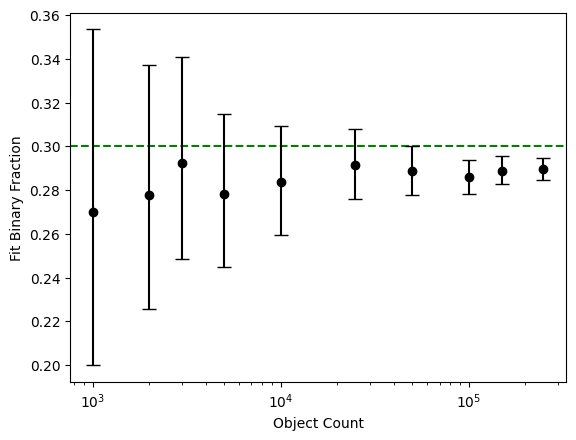

In [ ]:
meaned_res = np.mean(np.array(res), axis=1)
plt.errorbar(counts, meaned_res[:,0], yerr=(meaned_res[:,2], meaned_res[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(counts, meaned_res[:,0], marker='o', color='k', zorder=2);
plt.axhline(y=0.3, c="green", linestyle="--", zorder=0);
plt.xlabel("Object Count");
plt.ylabel("Fit Binary Fraction");
plt.xscale('log')

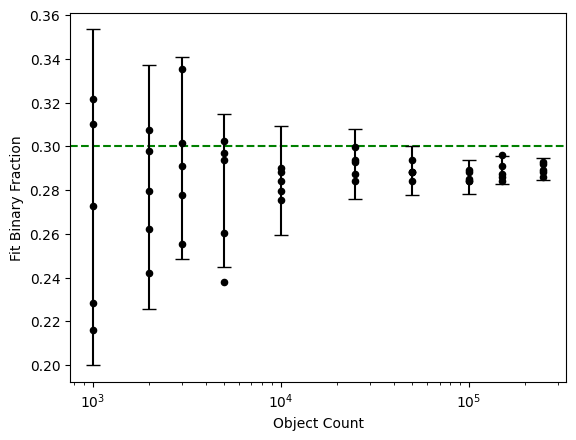

In [34]:
for i in range(5):
    plt.scatter(counts, res[:,i,0], marker='o', color='k', s=20, zorder=2);
plt.errorbar(counts, meaned_res[:,0], yerr=(meaned_res[:,2], meaned_res[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.axhline(y=0.3, c="green", linestyle="--", zorder=0);
plt.xlabel("Object Count");
plt.ylabel("Fit Binary Fraction");
plt.xscale('log')